In [20]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [21]:
from statiskit import (linalg,
                       core,
                       pgm)

In [22]:
import math
import os

In [23]:
%reload_ext rpy2.ipython

In [24]:
if not 'K' in os.environ:
    os.environ['K'] = str(10)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
graph0 = pgm.read_gml(os.path.join('results', 'graph.gml'))
data = core.read_csv(os.path.join('results', 'data.csv'))
data

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,$0.15$,$0.40$,$1.01$,$2.17$,$1.09$,$0.12$,$-1.34$,$-0.11$,$-0.54$,$-1.59$
1,$-0.64$,$-0.04$,$0.40$,$-0.72$,$0.50$,$-1.41$,$-0.26$,$-1.86$,$0.31$,$1.03$
2,$-0.10$,$-0.26$,$1.12$,$-1.81$,$2.49$,$0.03$,$-0.09$,$-1.18$,$-0.45$,$1.09$
3,$0.77$,$-1.75$,$1.50$,$-1.36$,$-0.68$,$-0.76$,$-1.01$,$2.85$,$0.72$,$0.49$
4,$0.17$,$1.15$,$-0.59$,$0.99$,$-0.32$,$-0.54$,$-0.26$,$-0.77$,$-0.08$,$0.25$
5,$-0.01$,$0.02$,$3.06$,$0.86$,$0.15$,$-0.13$,$-0.71$,$-0.36$,$1.34$,$-1.97$
6,$0.24$,$-0.00$,$1.16$,$-1.47$,$0.58$,$0.62$,$0.18$,$-1.09$,$-0.28$,$0.71$
7,$0.29$,$0.47$,$0.60$,$-0.52$,$-0.60$,$0.72$,$0.31$,$1.28$,$1.87$,$0.16$
8,$0.81$,$-0.48$,$1.15$,$1.19$,$-0.78$,$-0.00$,$0.61$,$1.35$,$-0.04$,$-1.40$
9,$0.12$,$-1.05$,$0.45$,$-1.67$,$-1.27$,$-0.46$,$-0.43$,$2.00$,$0.36$,$1.05$


In [25]:
%%R
library(glasso)

LASSO <- function(dat,penality){
  
  d=length(dat)
  sigma <- cov(dat)
  #penalitÃŠ linÃŠaire
  if (penality == "LINEAIR")
    lamda <- seq(0.001,max(sigma),length.out = 1+d*(d+1)/2)
  #penalitÃŠ avec les val de sigma
  else 
    lamda <- c(sigma[ upper.tri(sigma,diag = FALSE) ],0.001)
  
  lamda <- sort(abs(lamda),decreasing = TRUE)
  
  ############ON TOURNE LE LASSO POUR CHAQUE LAMDA##########
  j=1
  for(i in lamda){
    
    lasso.res  <- glasso(sigma,rho =i)
    write.table(lasso.res$wi, paste("lasso_", j, ".csv", sep=''), row.names=FALSE,col.names = FALSE, sep =" ")
    j=j+1
  }
}

In [26]:
if not 'LASSO' in os.environ:
    os.environ['LASSO'] = "AUTRE"
LAMBDA = os.environ.get('LASSO')
LAMBDA

'AUTRE'

In [27]:
%R data = read.csv('results/data.csv', header = F, sep="") 
%R print(data)
%R LASSO(data, Sys.getenv(c("LASSO"))[1])

            V1           V2         V3         V4         V5           V6
1   0.15957671  0.402231881  1.0168579  2.1780451  1.0944781  0.121518620
2  -0.64071842 -0.043346218  0.4099142 -0.7252210  0.5079029 -1.418157659
3  -0.10564328 -0.260799405  1.1224753 -1.8127936  2.4967444  0.036925877
4   0.77911352 -1.751453068  1.5018098 -1.3654422 -0.6870282 -0.760112374
5   0.17264584  1.152622347 -0.5924385  0.9933520 -0.3251874 -0.543909890
6  -0.01680708  0.022574573  3.0627486  0.8635723  0.1530799 -0.133328505
7   0.24443226 -0.008736016  1.1673491 -1.4702292  0.5842622  0.629147401
8   0.29884150  0.475789346  0.6054506 -0.5243534 -0.6088663  0.726843799
9   0.81825833 -0.484741292  1.1597611  1.1975434 -0.7861551 -0.008069555
10  0.12699700 -1.058195053  0.4583122 -1.6772595 -1.2792770 -0.468325794
            V7         V8          V9        V10
1  -1.34118934 -0.1128956 -0.54932977 -1.5936426
2  -0.26769871 -1.8675312  0.31337171  1.0304941
3  -0.09248255 -1.1811217 -0.45771978  

In [28]:
graphs = []
for filepath in os.listdir('.'):
    if filepath.startswith('lasso_'):
        adjmat = linalg.read_csv(filepath)
        graphs.append(pgm.UndirectedGraph(adjmat))
graphs = sorted(graphs, key = lambda graph: graph.nb_edges)

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 16.9 µs


<IPython.core.display.Javascript object>


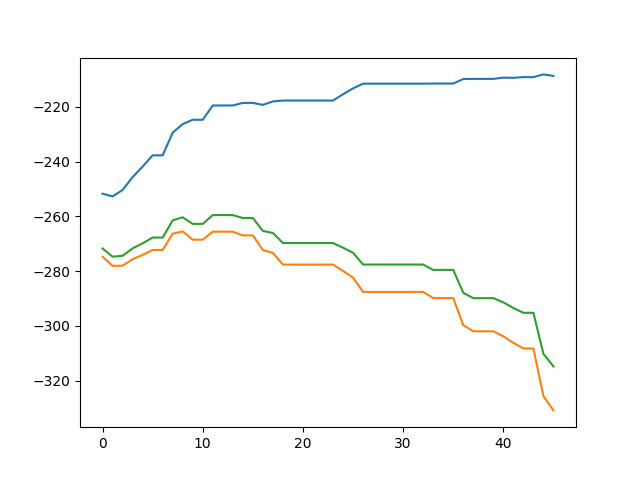

In [11]:
LLHs = []
BICs = []
AICs = []

%time
for graph in graphs:
    try:
        mle = pgm.graphical_gaussian_estimation(algo='scd',
                                                data=data,
                                                graph=graph)
        dist = mle.estimated.copy()

        LLHs.append(2 * dist.loglikelihood(data))
        
    except Exception as e:
        print e
        LLHs.append(float("nan"))
        BICs.append(LLHs[-1])
        AICs.append(LLHs[-1])
    else:
        BICs.append(LLHs[-1] - dist.nb_parameters * math.log(len(data.events)))
        AICs.append(LLHs[-1] - dist.nb_parameters * 2)

fig = pyplot.figure()
axes = fig.add_subplot(111)
axes.plot(LLHs)
axes.plot(BICs)
axes.plot(AICs)

In [29]:
aic = AICs.index(max(AICs))
bic = BICs.index(max(BICs))

<IPython.core.display.Javascript object>


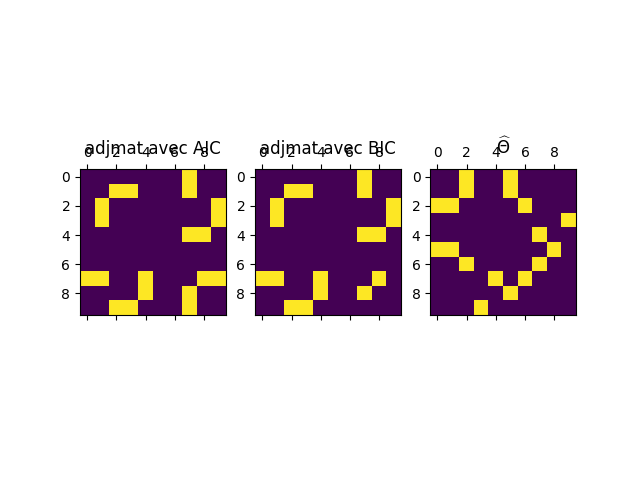

In [30]:
fig = pyplot.figure()
axes = graphs[aic].to_matrix().plot(axes = fig.add_subplot(131))
axes.set_title('adjmat avec AIC')
axes = graphs[bic].to_matrix().plot(axes = fig.add_subplot(132))
axes.set_title('adjmat avec BIC')
axes =  graph0.to_matrix().plot(axes = fig.add_subplot(133))
axes.set_title('$ \widehat \Theta$')